In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import transformers
from transformers import pipeline
# ~/.cache/huggingface/hub
from transformers import AutoTokenizer, AutoConfig, AutoModel
# ~/.cache/huggingface/datasets
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image
# default: 100
mpl.rcParams['figure.dpi'] = 150
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## summary

- t5: Text-To-Text Transfer Transformer
    - https://ai.googleblog.com/2020/02/exploring-transfer-learning-with-t5.html

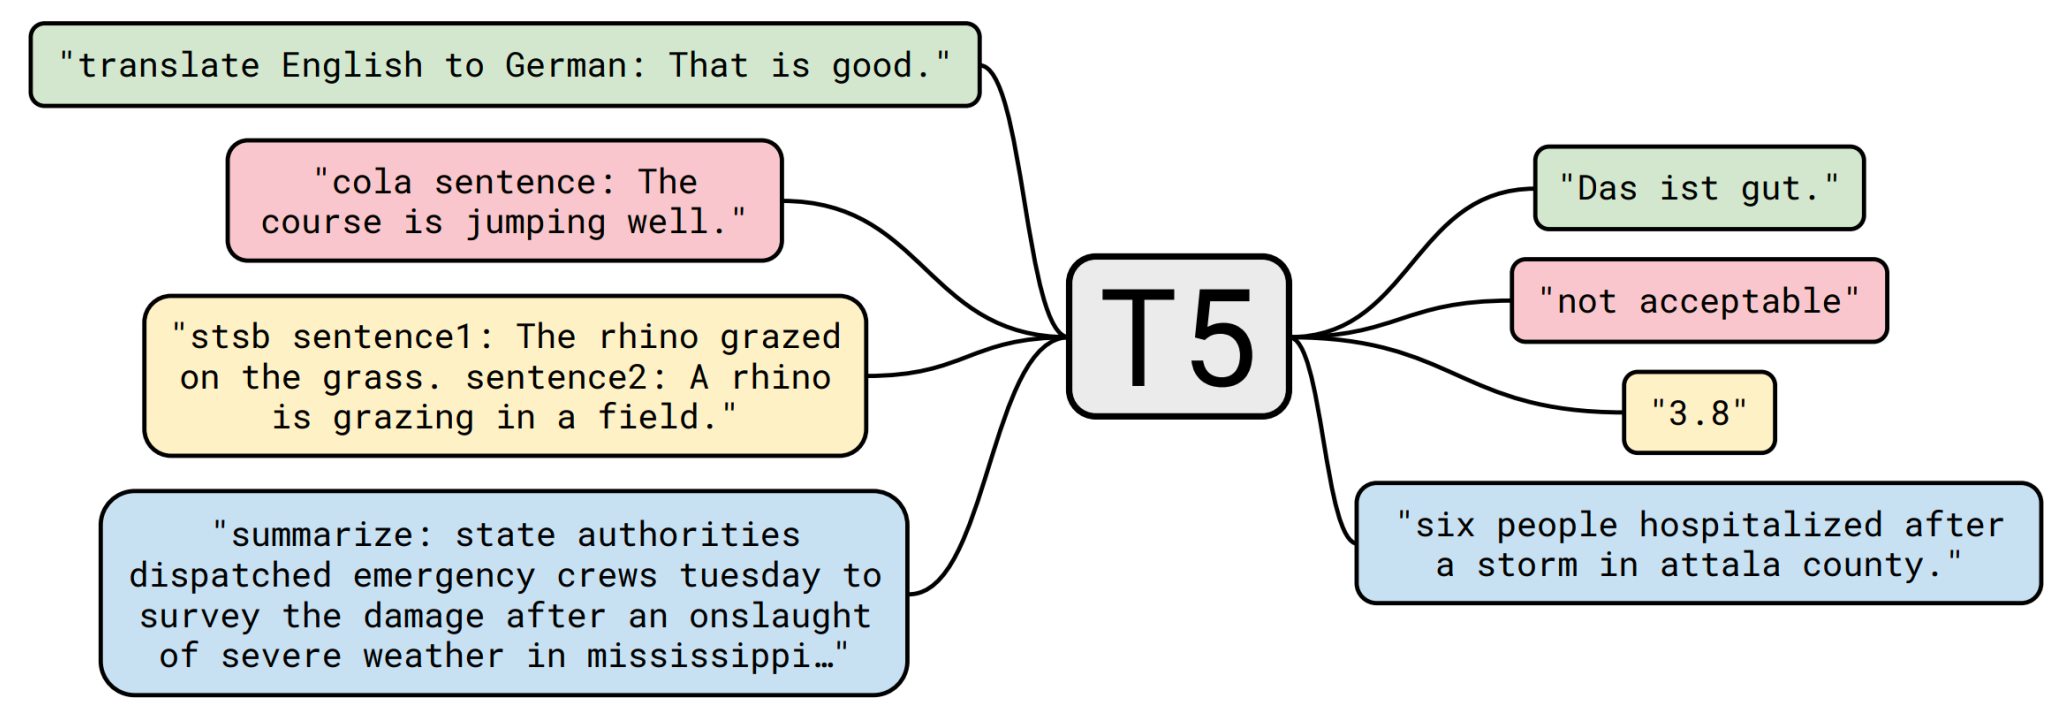

In [2]:
Image('../imgs/t5.png')

- CoLA: Linguistic Acceptability
    - Corpus of Linguistic Acceptability
- STSB: Semantic Textual Similarity Beachmark

## T5 model

In [3]:
from transformers import T5ForConditionalGeneration

In [4]:
# t5-small
# t5-base
# t5-large
# t5-3b
# tb-11b
model_ckpt = 't5-11b'

In [6]:
t5 = T5ForConditionalGeneration.from_pretrained(model_ckpt, device_map = 'auto')

In [7]:
t5

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=16384, bias=False)
              (k): Linear(in_features=1024, out_features=16384, bias=False)
              (v): Linear(in_features=1024, out_features=16384, bias=False)
              (o): Linear(in_features=16384, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 128)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=65536, bias=False)
              (wo): Linear(in_features=65536, out_features=1024, bias=False)
         

## summarization

- 长文本处理的难度

### dataset

In [3]:
from datasets import load_dataset

In [2]:
dataset = load_dataset("cnn_dailymail", version="3.0.0")

Found cached dataset cnn_dailymail (/home/whaow/.cache/huggingface/datasets/cnn_dailymail/default/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
print(dataset)
print(dataset['train'].features)
dataset['train'].column_names

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})
{'article': Value(dtype='string', id=None), 'highlights': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None)}


['article', 'highlights', 'id']

In [30]:
sample = dataset['train'][0]

In [31]:
print(type(sample))
print(sample.keys())
print(len(sample['article']))
print('highlights: ', sample['highlights'])
print(len(sample['highlights']))

<class 'dict'>
dict_keys(['article', 'highlights', 'id'])
2527
highlights:  Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in trust fund .
217


### summarization pipeline

- 分句
- baseline

In [39]:
# 2000 characters
sample_text = dataset['train'][0]['article'][:2000]
summarize = {}
sample_text

'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details o

#### 段落分句

In [32]:
import nltk
from nltk.tokenize import sent_tokenize

In [33]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/whaow/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [34]:
sentences = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(sentences)

['The U.S. are a country.', 'The U.N. is an organization.']

In [38]:
sent_tokenize(sample_text)

["LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him.",
 'Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties.',
 '"I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month.',
 '"I don\'t think I\'ll be particularly extravagant.',
 '"The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs."',
 'At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box off

#### baseline

In [35]:
def three_sentence_summary(text, first_k_sents=3):
    return "\n".join(sent_tokenize(text)[:first_k_sents])

In [40]:
summarize['baseline'] = three_sentence_summary(sample_text)